In [1]:
import ee
import pandas as pd

# Initialize the Earth Engine library
ee.Initialize(project='pranavkoka123')

geometry = ee.Geometry.Rectangle([78.97, 30.70, 79.20, 30.79])

# Function to calculate NDSI and apply confidence bit extraction
def calculate_ndsi_and_confidence(image):
    # NDSI = (Green - SWIR) / (Green + SWIR)
    green = image.select('B3')  # Green band
    swir = image.select('B6')  # SWIR band
    ndsi = green.subtract(swir).divide(green.add(swir)).rename('NDSI')

    # Extract snow/ice confidence (Bit 5) and cloud confidence (Bit 3)
    qa_pixel = image.select('QA_PIXEL')
    snow_confidence = qa_pixel.rightShift(5).bitwiseAnd(1).rename('Snow_Confidence')  # Bit 5
    cloud_confidence = qa_pixel.rightShift(3).bitwiseAnd(1).rename('Cloud_Confidence')  # Bit 3

    return image.addBands([ndsi, snow_confidence, cloud_confidence])

# Function to calculate the number of pixels for each snow/cloud combination
def calculate_pixel_counts(image):
    # Create masks for each S/C combination
    s0c0 = image.select('Snow_Confidence').eq(0).And(image.select('Cloud_Confidence').eq(0))
    s1c0 = image.select('Snow_Confidence').eq(1).And(image.select('Cloud_Confidence').eq(0))
    s0c1 = image.select('Snow_Confidence').eq(0).And(image.select('Cloud_Confidence').eq(1))
    s1c1 = image.select('Snow_Confidence').eq(1).And(image.select('Cloud_Confidence').eq(1))

    # Count the pixels for each combination, retrieve actual values using getInfo()
    counts = {
        's0c0': int(s0c0.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('Snow_Confidence').getInfo() or 0),
        's1c0': int(s1c0.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('Snow_Confidence').getInfo() or 0),
        's0c1': int(s0c1.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('Snow_Confidence').getInfo() or 0),
        's1c1': int(s1c1.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('Snow_Confidence').getInfo() or 0)
    }

    return counts

# Function to process images for each month of each year
def process_monthly_data(year, month):
    # Filter the image collection for the specific month
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    image = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                .filterDate(start_date, end_date) \
                .filterBounds(geometry) \
                .first()
    
    # Calculate NDSI and extract confidence bits
    image_ndsi_conf = calculate_ndsi_and_confidence(image)
    
    # Get pixel counts for each S/C combination
    pixel_counts = calculate_pixel_counts(image_ndsi_conf)
    
    # Add the year and month to the result
    return {
        'year': year,
        'month': month,
        's0c0': pixel_counts['s0c0'],
        's1c0': pixel_counts['s1c0'],
        's0c1': pixel_counts['s0c1'],
        's1c1': pixel_counts['s1c1']
    }

# Loop over the years and months to generate the dataframe
results = []
for year in range(2013, 2024):
    if year == 2013:
        for month in range(4,13):
            result = process_monthly_data(year, month)
            results.append(result)
    else:    
        for month in range(1, 13):
            result = process_monthly_data(year, month)
            results.append(result)

# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
print(df)


     year  month    s0c0   s1c0    s0c1  s1c1
0    2013      4   50597  36094  157484     0
1    2013      5   51440  71532  120772     0
2    2013      6   35263  42887  166026     0
3    2013      7   44537  58378  141261     0
4    2013      8   14118   9153  220904     0
..    ...    ...     ...    ...     ...   ...
124  2023      8   49624  37174  157377     0
125  2023      9   82249    359  156412     0
126  2023     10  172963  29234   41979     0
127  2023     11   53284  44634  144278     0
128  2023     12    4484      0  239692     0

[129 rows x 6 columns]


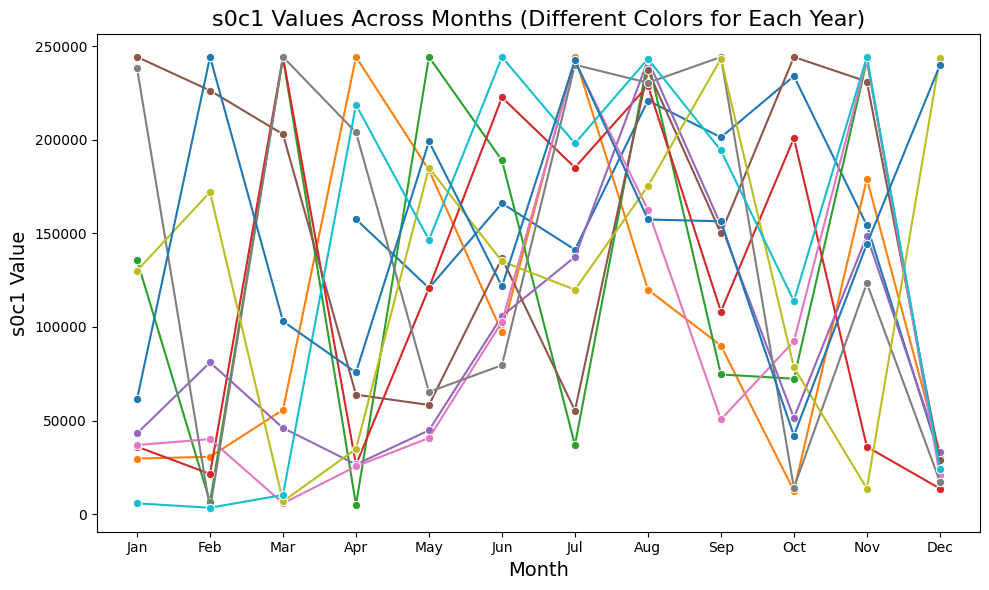

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month', y='s0c1', hue='year', marker='o', palette='tab10', legend=False)

plt.title('s0c1 Values Across Months (Different Colors for Each Year)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('s0c1 Value', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\3257993956.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='s0c1', palette='tab10')


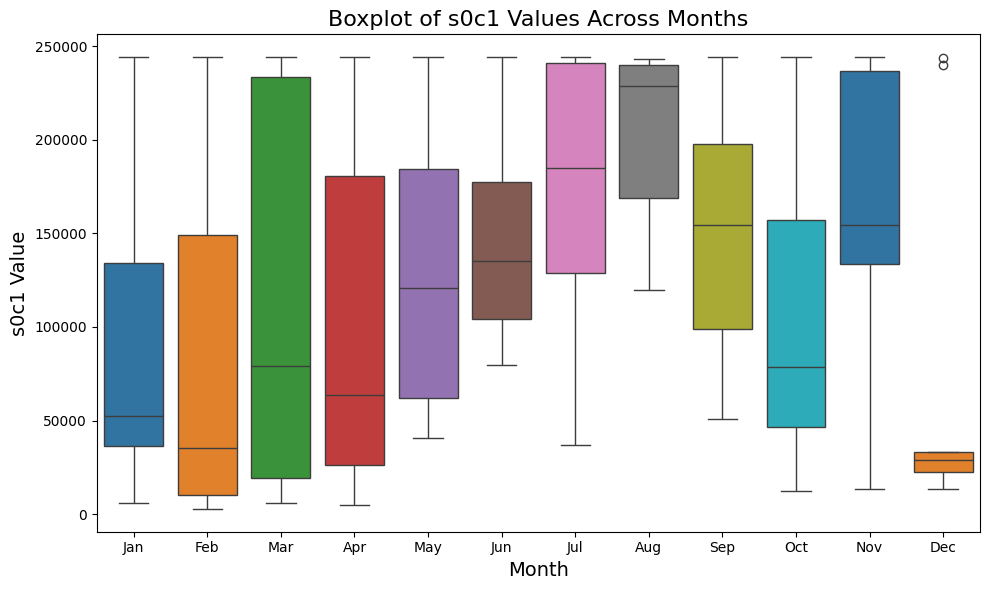

In [3]:
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)

# Create a figure for the boxplot
plt.figure(figsize=(10, 6))

# Generate a boxplot
sns.boxplot(data=df, x='month', y='s0c1', palette='tab10')

# Add plot title and labels
plt.title('Boxplot of s0c1 Values Across Months', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('s0c1 Value', fontsize=14)

# Set month labels on the x-axis
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [4]:
monthly_mean_s0c1 = df.groupby('month')['s0c1'].mean()
print(monthly_mean_s0c1)
monthly_median_s0c1 = df.groupby('month')['s0c1'].median()
print(monthly_median_s0c1)


month
1      96104.800000
2      82853.000000
3     116281.400000
4      98366.818182
5     128110.272727
6     145483.545455
7     167488.818182
8     205494.636364
9     151547.181818
10    105079.909091
11    159985.727273
12     64484.727273
Name: s0c1, dtype: float64
month
1      52255.0
2      35390.0
3      79400.0
4      63830.0
5     120811.0
6     135032.0
7     185119.0
8     228895.0
9     154418.0
10     78440.0
11    154236.0
12     28985.0
Name: s0c1, dtype: float64


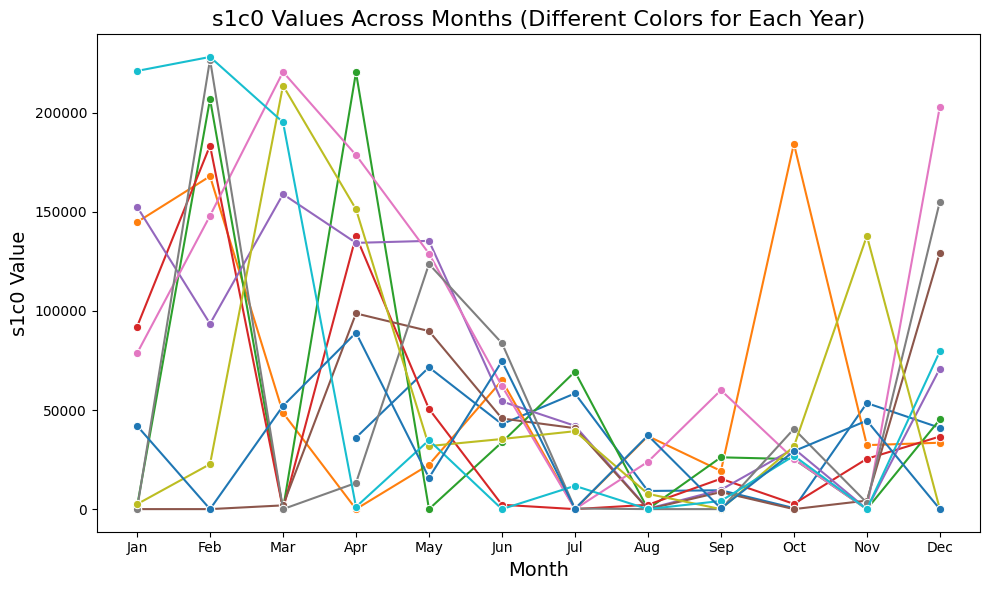

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month', y='s1c0', hue='year', marker='o', palette='tab10', legend=False)

plt.title('s1c0 Values Across Months (Different Colors for Each Year)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('s1c0 Value', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\1894947458.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='s1c0', palette='tab10')


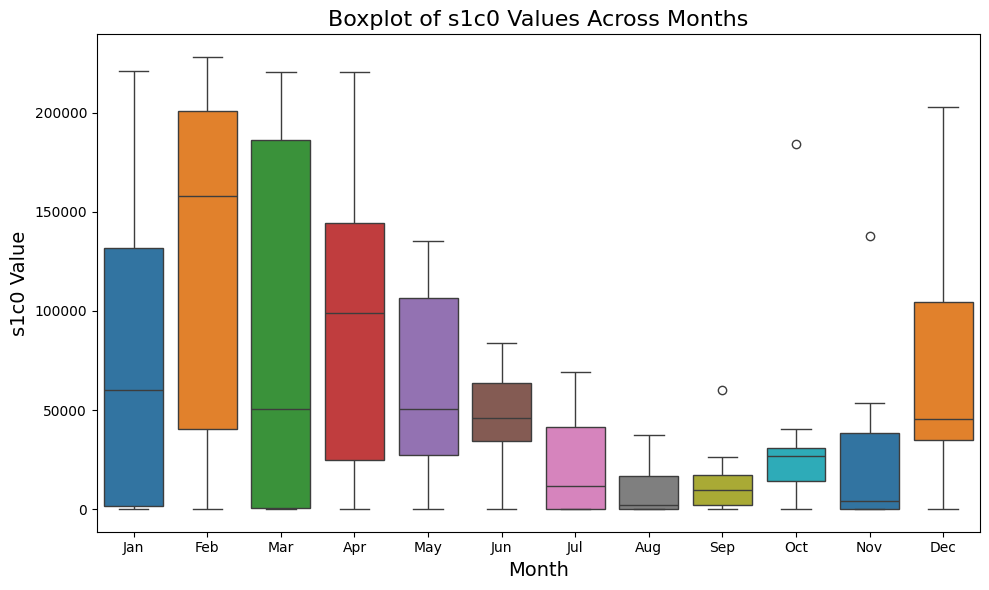

In [6]:
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)

# Create a figure for the boxplot
plt.figure(figsize=(10, 6))

# Generate a boxplot
sns.boxplot(data=df, x='month', y='s1c0', palette='tab10')

# Add plot title and labels
plt.title('Boxplot of s1c0 Values Across Months', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('s1c0 Value', fontsize=14)

# Set month labels on the x-axis
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
monthly_mean_s1c0 = df.groupby('month')['s1c0'].mean()
print(monthly_mean_s1c0)
monthly_median_s1c0 = df.groupby('month')['s1c0'].median()
print(monthly_median_s1c0)


month
1      73491.200000
2     127746.800000
3      89094.200000
4      96411.454545
5      64059.181818
6      45423.363636
7      23829.454545
8      10646.000000
9      13910.818182
10     36070.636364
11     27374.363636
12     72245.272727
Name: s1c0, dtype: float64
month
1      60326.5
2     157988.0
3      50329.5
4      98736.0
5      50559.0
6      45738.0
7      11734.0
8       2180.0
9       9504.0
10     26899.0
11      4294.0
12     45218.0
Name: s1c0, dtype: float64


In [8]:
# Function to calculate NDSI and apply confidence bit extraction
def calculate_ndsi_and_confidence(image):
    # NDSI = (Green - SWIR) / (Green + SWIR)
    green = image.select('B3')  # Green band
    swir = image.select('B6')  # SWIR band
    ndsi = green.subtract(swir).divide(green.add(swir)).rename('NDSI')

    # Extract snow/ice confidence (Bit 5) and cloud confidence (Bit 3)
    qa_pixel = image.select('QA_PIXEL')
    snow_confidence = qa_pixel.rightShift(5).bitwiseAnd(1).rename('Snow_Confidence')  # Bit 5
    cloud_confidence = qa_pixel.rightShift(3).bitwiseAnd(1).rename('Cloud_Confidence')  # Bit 3

    return image.addBands([ndsi, snow_confidence, cloud_confidence])

def calculate_ndsi_percentage(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                        .filterDate(start_date, end_date) \
                        .filterBounds(geometry)

    # Calculate NDSI for each image in the collection
    images = image_collection.toList(image_collection.size())
    ndsi_values = []
    
    for i in range(images.size().getInfo()):
        image = ee.Image(images.get(i))
        image_ndsi_conf = calculate_ndsi_and_confidence(image)
        ndsi = image_ndsi_conf.select('NDSI')
        
        # Count pixels with NDSI > 0.6
        ndsi_mask = ndsi.gt(0.6)
        ndsi_count = ndsi_mask.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('NDSI').getInfo() or 0
        
        # Total pixels in the image
        total_pixels = image.select('B3').reduceRegion(ee.Reducer.count(), geometry, scale=30).get('B3').getInfo() or 1
        
        # Calculate percentage
        percentage = (ndsi_count / total_pixels) * 100 if total_pixels > 0 else 0
        ndsi_values.append(percentage)

    # Calculate average percentage for the month
    average_percentage = sum(ndsi_values) / len(ndsi_values) if ndsi_values else 0
    
    return {
        'year': year,
        'month': month,
        'ndsi_percentage': average_percentage
    }

ndsi_results = []
for year in range(2013, 2024):
    if year == 2013:
        for month in [4,12]:
            result = calculate_ndsi_percentage(year, month)
            ndsi_results.append(result)
    else:
        for month in [1, 2, 3, 4, 12]: 
            result = calculate_ndsi_percentage(year, month)
            ndsi_results.append(result)

ndsi_df = pd.DataFrame(ndsi_results)

print(ndsi_df)

    year  month  ndsi_percentage
0   2013      4        61.101966
1   2013     12        53.339418
2   2014      1        88.551039
3   2014      2        91.322983
4   2014      3        94.626546
5   2014      4        74.128459
6   2014     12        57.986915
7   2015      1        62.932239
8   2015      2        93.073553
9   2015      3        49.195886
10  2015      4        84.644388
11  2015     12        67.045696
12  2016      1        44.933063
13  2016      2        82.717656
14  2016      3        62.104101
15  2016      4        67.133255
16  2016     12        18.878517
17  2017      1        32.030745
18  2017      2        78.908631
19  2017      3        92.843501
20  2017      4        24.145589
21  2017     12        58.575889
22  2018      1        63.109954
23  2018      2        74.552015
24  2018      3        86.368379
25  2018      4        58.117296
26  2018     12        76.330232
27  2019      1        25.560944
28  2019      2        88.113974
29  2019  

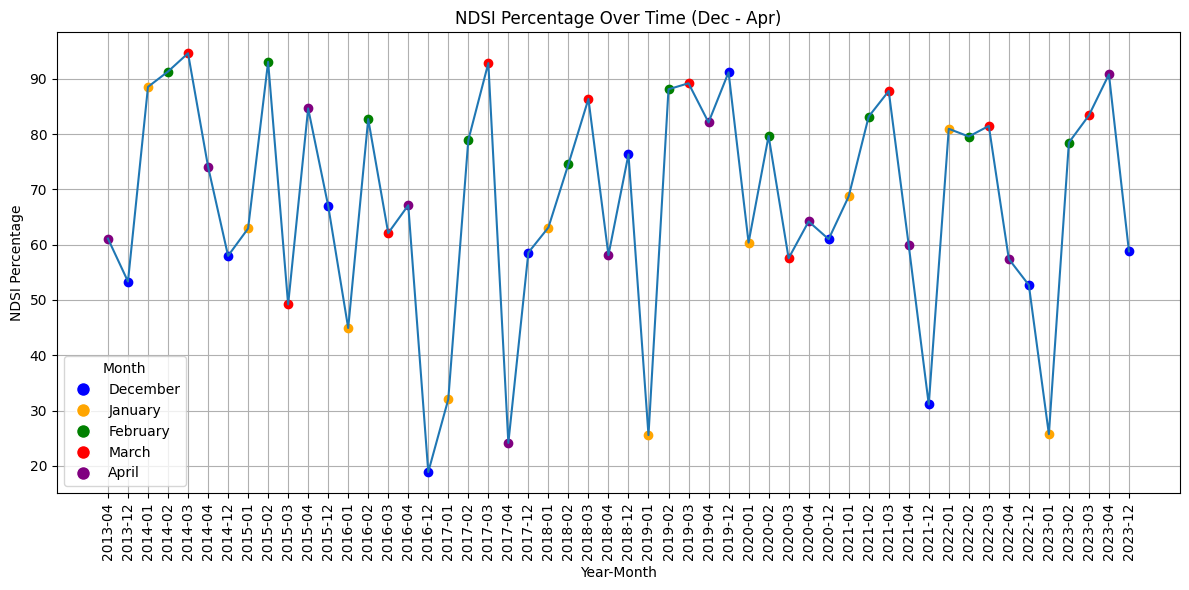

In [9]:
ndsi_df['Year-Month'] = ndsi_df['year'].astype(str) + '-' + ndsi_df['month'].astype(str).str.zfill(2)

# Define colors for each month
month_colors = {
    12: 'blue',  # December
    1: 'orange',  # January
    2: 'green',   # February
    3: 'red',     # March
    4: 'purple'   # April
}

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each data point with a specific color based on the month
for index, row in ndsi_df.iterrows():
    plt.plot(row['Year-Month'], row['ndsi_percentage'], 
             marker='o', linestyle='-', color=month_colors[row['month']])

# Adding labels and titles
plt.xticks(rotation=90)
plt.title('NDSI Percentage Over Time (Dec - Apr)')
plt.xlabel('Year-Month')
plt.ylabel('NDSI Percentage')
plt.grid()
plt.plot(ndsi_df['Year-Month'], ndsi_df['ndsi_percentage'], linestyle='-')

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='December', markerfacecolor='blue', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='January', markerfacecolor='orange', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='February', markerfacecolor='green', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='March', markerfacecolor='red', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='April', markerfacecolor='purple', markersize=10)]
plt.legend(handles=handles, title='Month')
plt.tight_layout()
plt.show()

In [10]:
from tqdm import tqdm

def process_monthly_data(year, month):
    # Filter the image collection for the specific month
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    # Get the first image within the date range
    image = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                .filterDate(start_date, end_date) \
                .filterBounds(geometry) \
                .first()

    # Calculate NDSI and extract confidence bits
    image_ndsi_conf = calculate_ndsi_and_confidence(image)

    # Get the pixel-wise NDSI and confidence data
    data = image_ndsi_conf.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=geometry,
        scale=30,
        maxPixels=1e8
    ).getInfo()

    # Extract the list of NDSI, Snow_Confidence, and Cloud_Confidence values
    ndsi_values = data.get('NDSI', [])
    snow_confidence_values = data.get('Snow_Confidence', [])
    cloud_confidence_values = data.get('Cloud_Confidence', [])

    # Check if all lists have the same length
    min_length = min(len(ndsi_values), len(snow_confidence_values), len(cloud_confidence_values))
    
    if min_length == 0:
        print(f"No data for year {year}, month {month}. Skipping.")
        return []

    # Prepare a list of records for this month-year combination
    month_data = []
    for i in range(min_length):  # Ensure to loop through the minimum length
        month_data.append({
            'year': year,
            'month': month,
            'ndsi': ndsi_values[i],
            's1c0': int(snow_confidence_values[i] == 1 and cloud_confidence_values[i] == 0),
            's0c1': int(snow_confidence_values[i] == 0 and cloud_confidence_values[i] == 1)
        })

    return month_data

# Loop over the years and months to generate the dataframe
results = []
for year in tqdm(range(2013, 2024)):
    if year == 2013:
        for month in range(4, 13):
            month_data = process_monthly_data(year, month)
            results.extend(month_data)
    else:
        for month in range(1, 13):
            month_data = process_monthly_data(year, month)
            results.extend(month_data)

# Convert the results to a DataFrame
df_pure_ndsi = pd.DataFrame(results)

# Display the DataFrame
print(df_pure_ndsi)

100%|██████████| 11/11 [32:19<00:00, 176.28s/it]


          year  month      ndsi  s1c0  s0c1
0         2013      4  0.910321     1     0
1         2013      4  0.892737     1     0
2         2013      4  0.906224     1     0
3         2013      4  0.913146     1     0
4         2013      4  0.908325     1     0
...        ...    ...       ...   ...   ...
31282432  2023     12  0.152556     0     1
31282433  2023     12  0.189361     0     1
31282434  2023     12  0.203230     0     1
31282435  2023     12  0.188041     0     1
31282436  2023     12  0.173126     0     1

[31282437 rows x 5 columns]


In [43]:
def new_calculate_ndsi_and_confidence(image):
    # NDSI = (Green - SWIR) / (Green + SWIR)
    green = image.select('B3').rename('Green')  # Green band
    swir = image.select('B6').rename('SWIR')  # SWIR band
    ndsi = green.subtract(swir).divide(green.add(swir)).rename('NDSI')

    # Extract snow/ice confidence (Bit 5) and cloud confidence (Bit 3)
    qa_pixel = image.select('QA_PIXEL')
    snow_confidence = qa_pixel.rightShift(5).bitwiseAnd(1).rename('Snow_Confidence')  # Bit 5
    cloud_confidence = qa_pixel.rightShift(3).bitwiseAnd(1).rename('Cloud_Confidence')  # Bit 3

    return image.addBands([ndsi, snow_confidence, cloud_confidence, green, swir])

def new_process_monthly_data(year, month):
    # Filter the image collection for the specific month
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    # Get the first image within the date range
    image = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                .filterDate(start_date, end_date) \
                .filterBounds(geometry) \
                .first()
    
    # Check if there is an image for the month
    if image is None:
        print(f"No image found for year {year}, month {month}. Skipping.")
        return []

    # Calculate NDSI and extract confidence bits
    image_ndsi_conf = new_calculate_ndsi_and_confidence(image)

    # Get the pixel-wise NDSI and confidence data
    data = image_ndsi_conf.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=geometry,
        scale=30,
        maxPixels=1e8
    ).getInfo()

    # Extract the list of NDSI, SWIR, and Green values
    ndsi_values = data.get('NDSI', [])
    swir = data.get('SWIR', [])
    green = data.get('Green', [])

    # Check if all lists have the same length
    min_length = min(len(ndsi_values), len(swir), len(green))
    
    if min_length == 0:
        print(f"No data for year {year}, month {month}. Skipping.")
        return []

    # Prepare a list of records for this month-year combination
    month_data = []
    for i in range(len(swir)):  # Ensure to loop through the minimum length
        month_data.append({
            'year': year,
            'month': month,
            'ndsi': ndsi_values[i],
            'swir': swir[i],
            'green': green[i]
        })

    return month_data

results = []
for month in tqdm(range(1, 13)):
    month_data = new_process_monthly_data(2014, month)
    results.extend(month_data)

df_bands = pd.DataFrame(results)

# Display the DataFrame
print(df_bands)

100%|██████████| 12/12 [03:42<00:00, 18.53s/it]


         year  month      ndsi      swir     green
0        2014      1  0.677297  0.113967  0.592361
1        2014      1  0.725048  0.063696  0.399631
2        2014      1  0.728737  0.080404  0.512405
3        2014      1  0.722133  0.093568  0.579905
4        2014      1  0.721051  0.084357  0.520460
...       ...    ...       ...       ...       ...
2929951  2014     12 -0.428797  0.415867  0.166255
2929952  2014     12 -0.425387  0.394222  0.158922
2929953  2014     12 -0.345655  0.432022  0.210077
2929954  2014     12 -0.454259  0.425184  0.159559
2929955  2014     12 -0.428302  0.429081  0.171746

[2929956 rows x 5 columns]


In [41]:
start_date = ee.Date.fromYMD(2014, 12, 1)
end_date = start_date.advance(1, 'month')

check = new_calculate_ndsi_and_confidence(ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                .filterDate(start_date, end_date) \
                .filterBounds(geometry) \
                .first()).reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=geometry,
        scale=30,
        maxPixels=1e8
    ).getInfo().get('Green',[])

In [12]:
df_pure_ndsi.to_csv("pure_ndsi")

C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\2343936322.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\2343936322.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\2343936322.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\2343936322.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtick

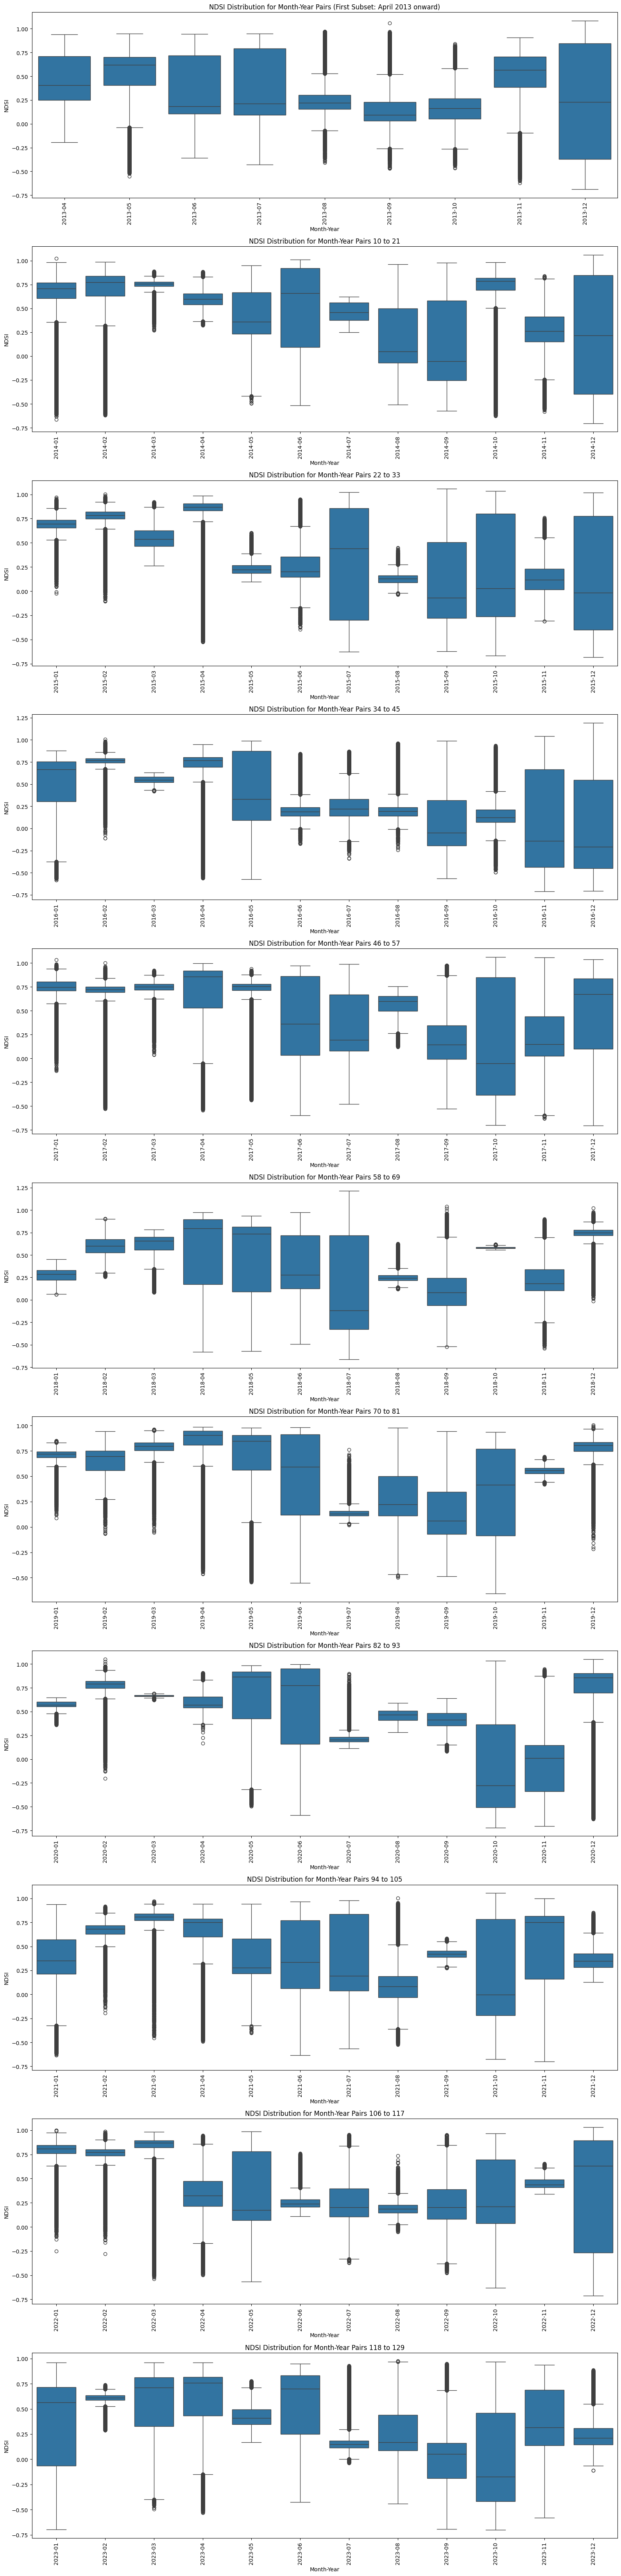

In [11]:
import math

# Add a 'month_year' column if it hasn't been done already
df_pure_ndsi['month_year'] = df_pure_ndsi['year'].astype(str) + '-' + df_pure_ndsi['month'].astype(str).str.zfill(2)

# Set the number of box plots for the first and subsequent subplots
first_subplot_plots = 9
subsequent_plots_per_subplot = 12

# Get the unique month_year pairs
unique_month_years = df_pure_ndsi['month_year'].unique()

# Calculate the total number of subplots needed
remaining_plots = len(unique_month_years) - first_subplot_plots
num_subsequent_subplots = math.ceil(remaining_plots / subsequent_plots_per_subplot)
total_subplots = 1 + num_subsequent_subplots  # 1 for the first subplot + subsequent subplots

# Create subplots
fig, axes = plt.subplots(total_subplots, 1, figsize=(16, 6 * total_subplots))

# Ensure axes is iterable even if there's only one subplot
if total_subplots == 1:
    axes = [axes]

# Create the first subplot (for April 2013 onwards)
first_subset = unique_month_years[:first_subplot_plots]
df_first_subset = df_pure_ndsi[df_pure_ndsi['month_year'].isin(first_subset)]
sns.boxplot(x='month_year', y='ndsi', data=df_first_subset, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title(f'NDSI Distribution for Month-Year Pairs (First Subset: April 2013 onward)')
axes[0].set_xlabel('Month-Year')
axes[0].set_ylabel('NDSI')

# Loop through the remaining subsets for subsequent subplots
for i, ax in enumerate(axes[1:]):
    start_idx = first_subplot_plots + i * subsequent_plots_per_subplot
    end_idx = start_idx + subsequent_plots_per_subplot
    
    # Get the subset of month_year pairs for this subplot
    subset_month_years = unique_month_years[start_idx:end_idx]
    
    # Filter the DataFrame for this subset
    df_subset = df_pure_ndsi[df_pure_ndsi['month_year'].isin(subset_month_years)]
    
    # Create the box plot for this subset
    sns.boxplot(x='month_year', y='ndsi', data=df_subset, ax=ax)
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    # Set plot title for this subplot
    ax.set_title(f'NDSI Distribution for Month-Year Pairs {start_idx + 1} to {min(end_idx, len(unique_month_years))}')
    
    # Set x and y labels
    ax.set_xlabel('Month-Year')
    ax.set_ylabel('NDSI')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\2711213095.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dec_to_apr['month_year'] = df_dec_to_apr['year'].astype(str) + '-' + df_dec_to_apr['month'].astype(str).str.zfill(2)
C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\2711213095.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\2711213095.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rota

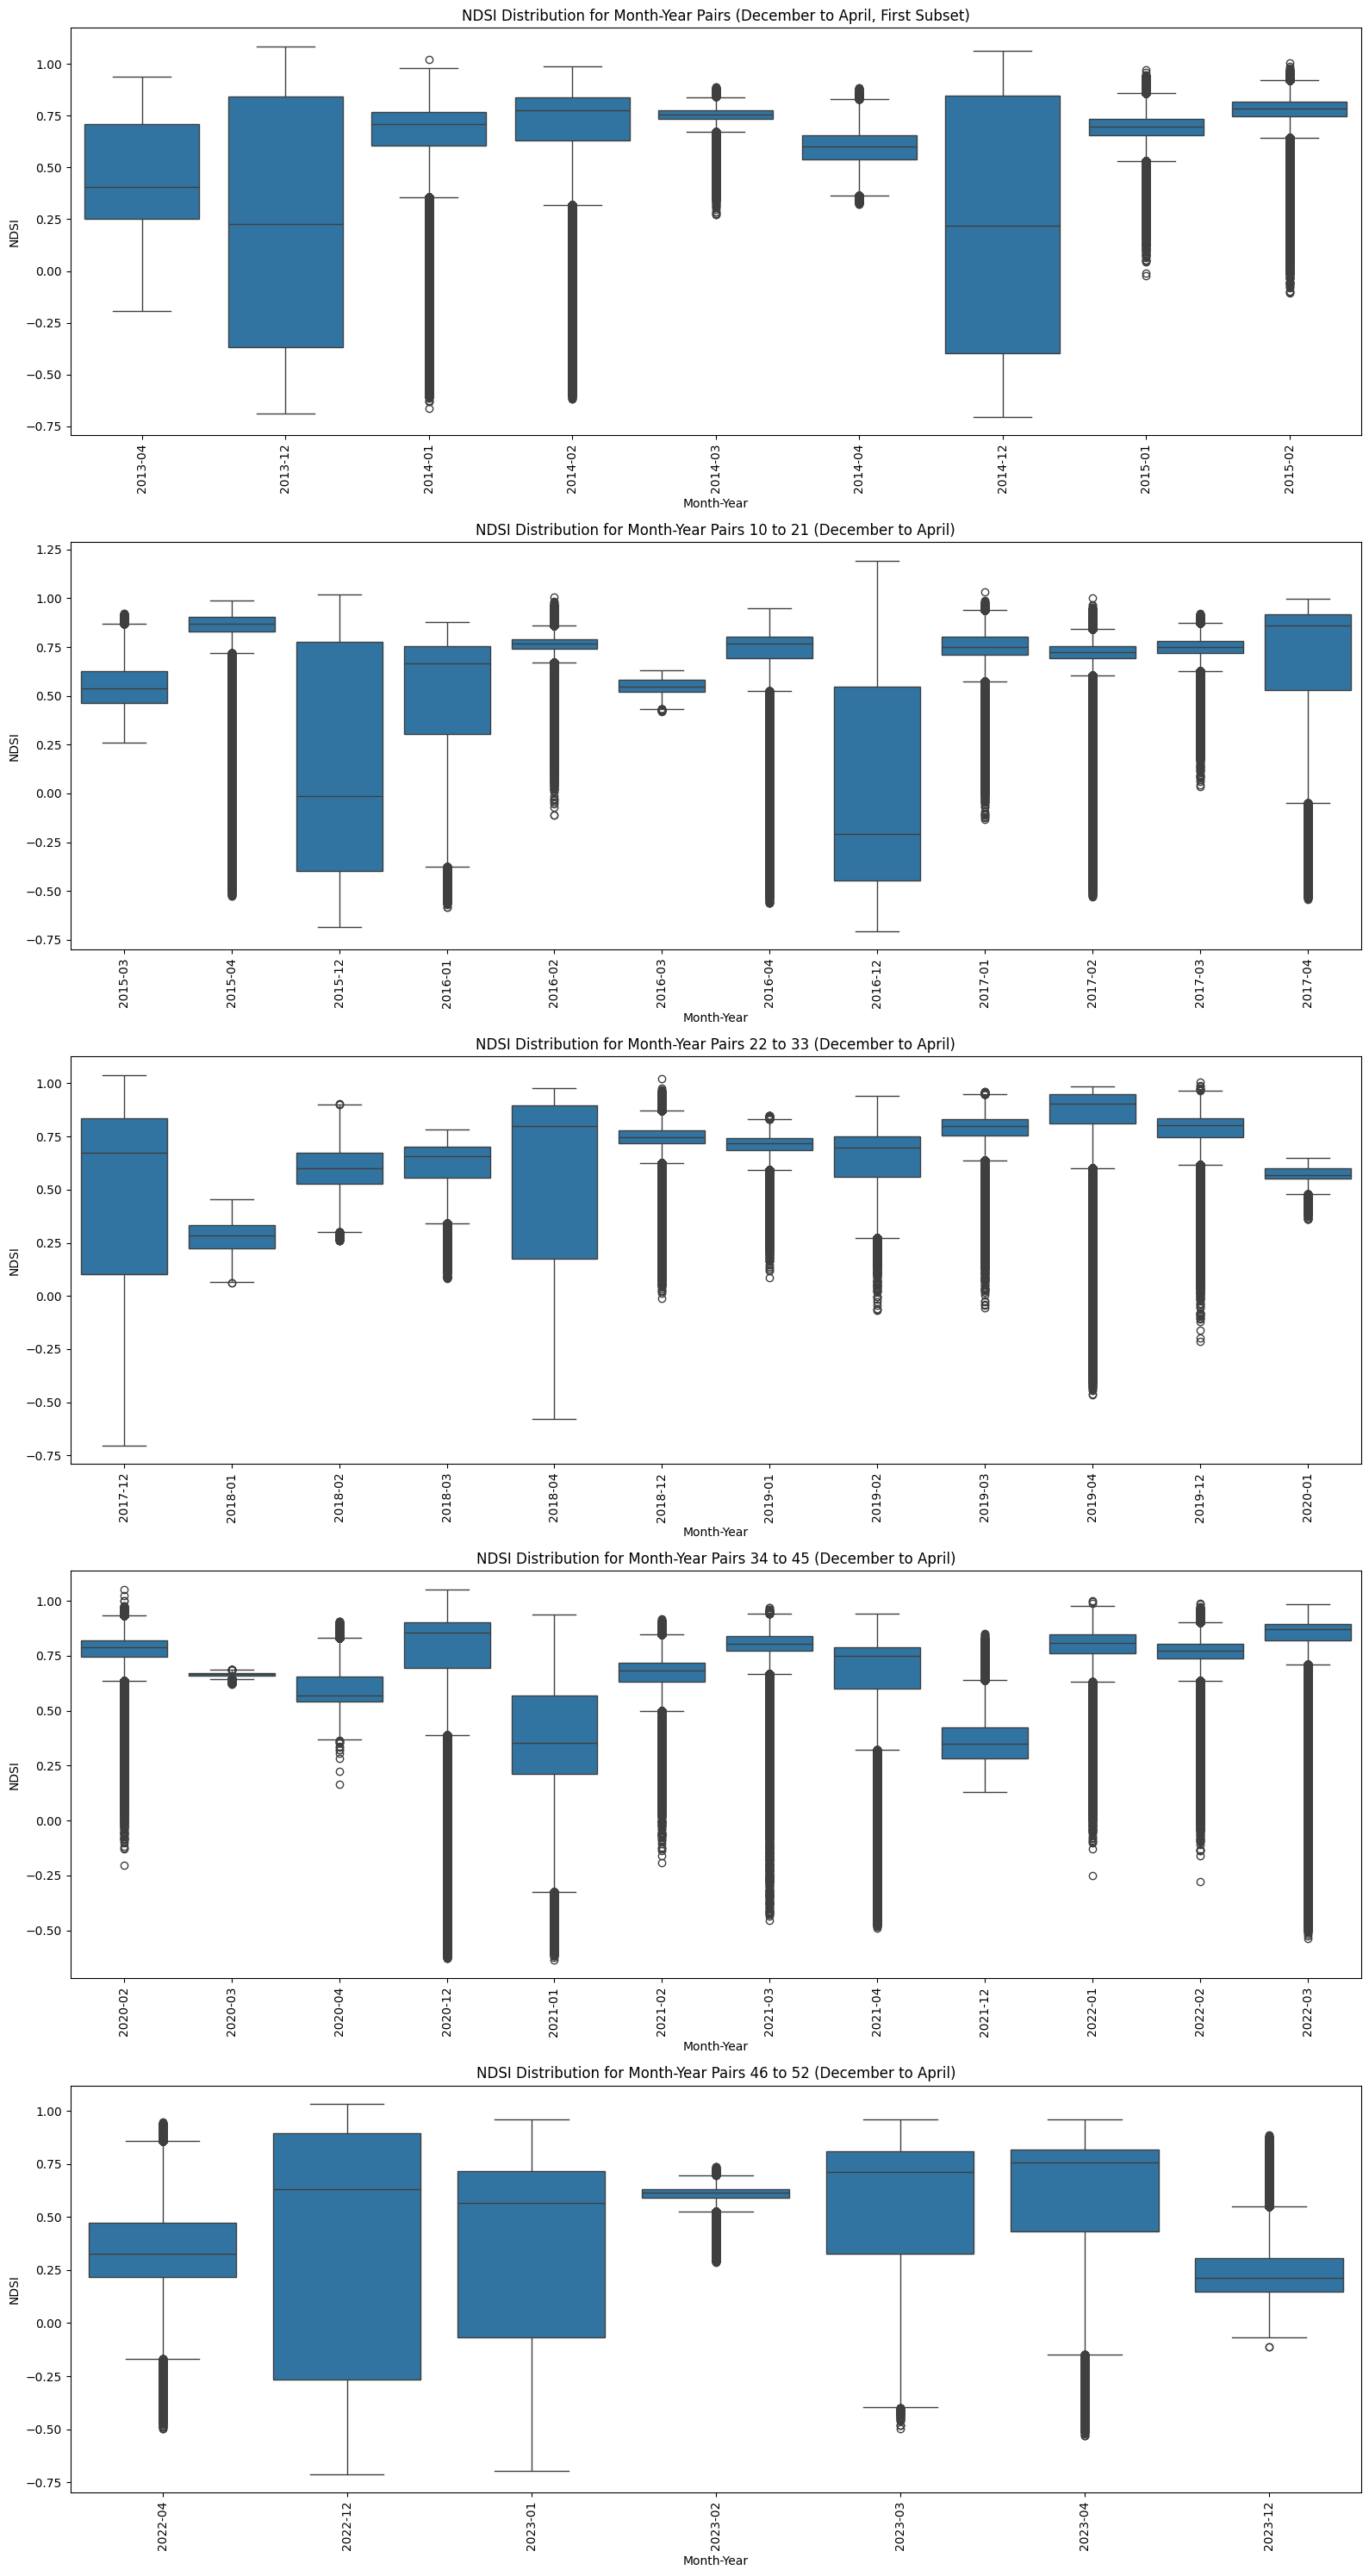

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Filter the DataFrame for only December (12) to April (4) months
df_dec_to_apr = df_pure_ndsi[df_pure_ndsi['month'].isin([12, 1, 2, 3, 4])]

# Add 'month_year' column if not already added
df_dec_to_apr['month_year'] = df_dec_to_apr['year'].astype(str) + '-' + df_dec_to_apr['month'].astype(str).str.zfill(2)

# Define number of box plots per subplot: first 9, then 12
first_subplot_plots = 9
subsequent_plots_per_subplot = 12

# Get the unique month-year pairs for the filtered data
unique_month_years = df_dec_to_apr['month_year'].unique()

# Calculate the number of subplots needed
remaining_plots = len(unique_month_years) - first_subplot_plots
num_subsequent_subplots = math.ceil(remaining_plots / subsequent_plots_per_subplot)
total_subplots = 1 + num_subsequent_subplots  # 1 for the first subplot + subsequent subplots

# Create subplots
fig, axes = plt.subplots(total_subplots, 1, figsize=(16, 6 * total_subplots))

# Ensure axes is iterable even if there's only one subplot
if total_subplots == 1:
    axes = [axes]

# Create the first subplot (for the first 9 month-year pairs)
first_subset = unique_month_years[:first_subplot_plots]
df_first_subset = df_dec_to_apr[df_dec_to_apr['month_year'].isin(first_subset)]
sns.boxplot(x='month_year', y='ndsi', data=df_first_subset, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title(f'NDSI Distribution for Month-Year Pairs (December to April, First Subset)')
axes[0].set_xlabel('Month-Year')
axes[0].set_ylabel('NDSI')

# Loop through remaining subsets for subsequent subplots
for i, ax in enumerate(axes[1:]):
    start_idx = first_subplot_plots + i * subsequent_plots_per_subplot
    end_idx = start_idx + subsequent_plots_per_subplot
    
    # Get the subset of month-year pairs for this subplot
    subset_month_years = unique_month_years[start_idx:end_idx]
    
    # Filter the DataFrame for this subset
    df_subset = df_dec_to_apr[df_dec_to_apr['month_year'].isin(subset_month_years)]
    
    # Create the box plot for this subset
    sns.boxplot(x='month_year', y='ndsi', data=df_subset, ax=ax)
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    # Set plot title for this subplot
    ax.set_title(f'NDSI Distribution for Month-Year Pairs {start_idx + 1} to {min(end_idx, len(unique_month_years))} (December to April)')
    
    # Set x and y labels
    ax.set_xlabel('Month-Year')
    ax.set_ylabel('NDSI')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\3483735124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dec_to_apr['month_year'] = df_dec_to_apr['year'].astype(str) + '-' + df_dec_to_apr['month'].astype(str).str.zfill(2)
C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\3483735124.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_25472\3483735124.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_x

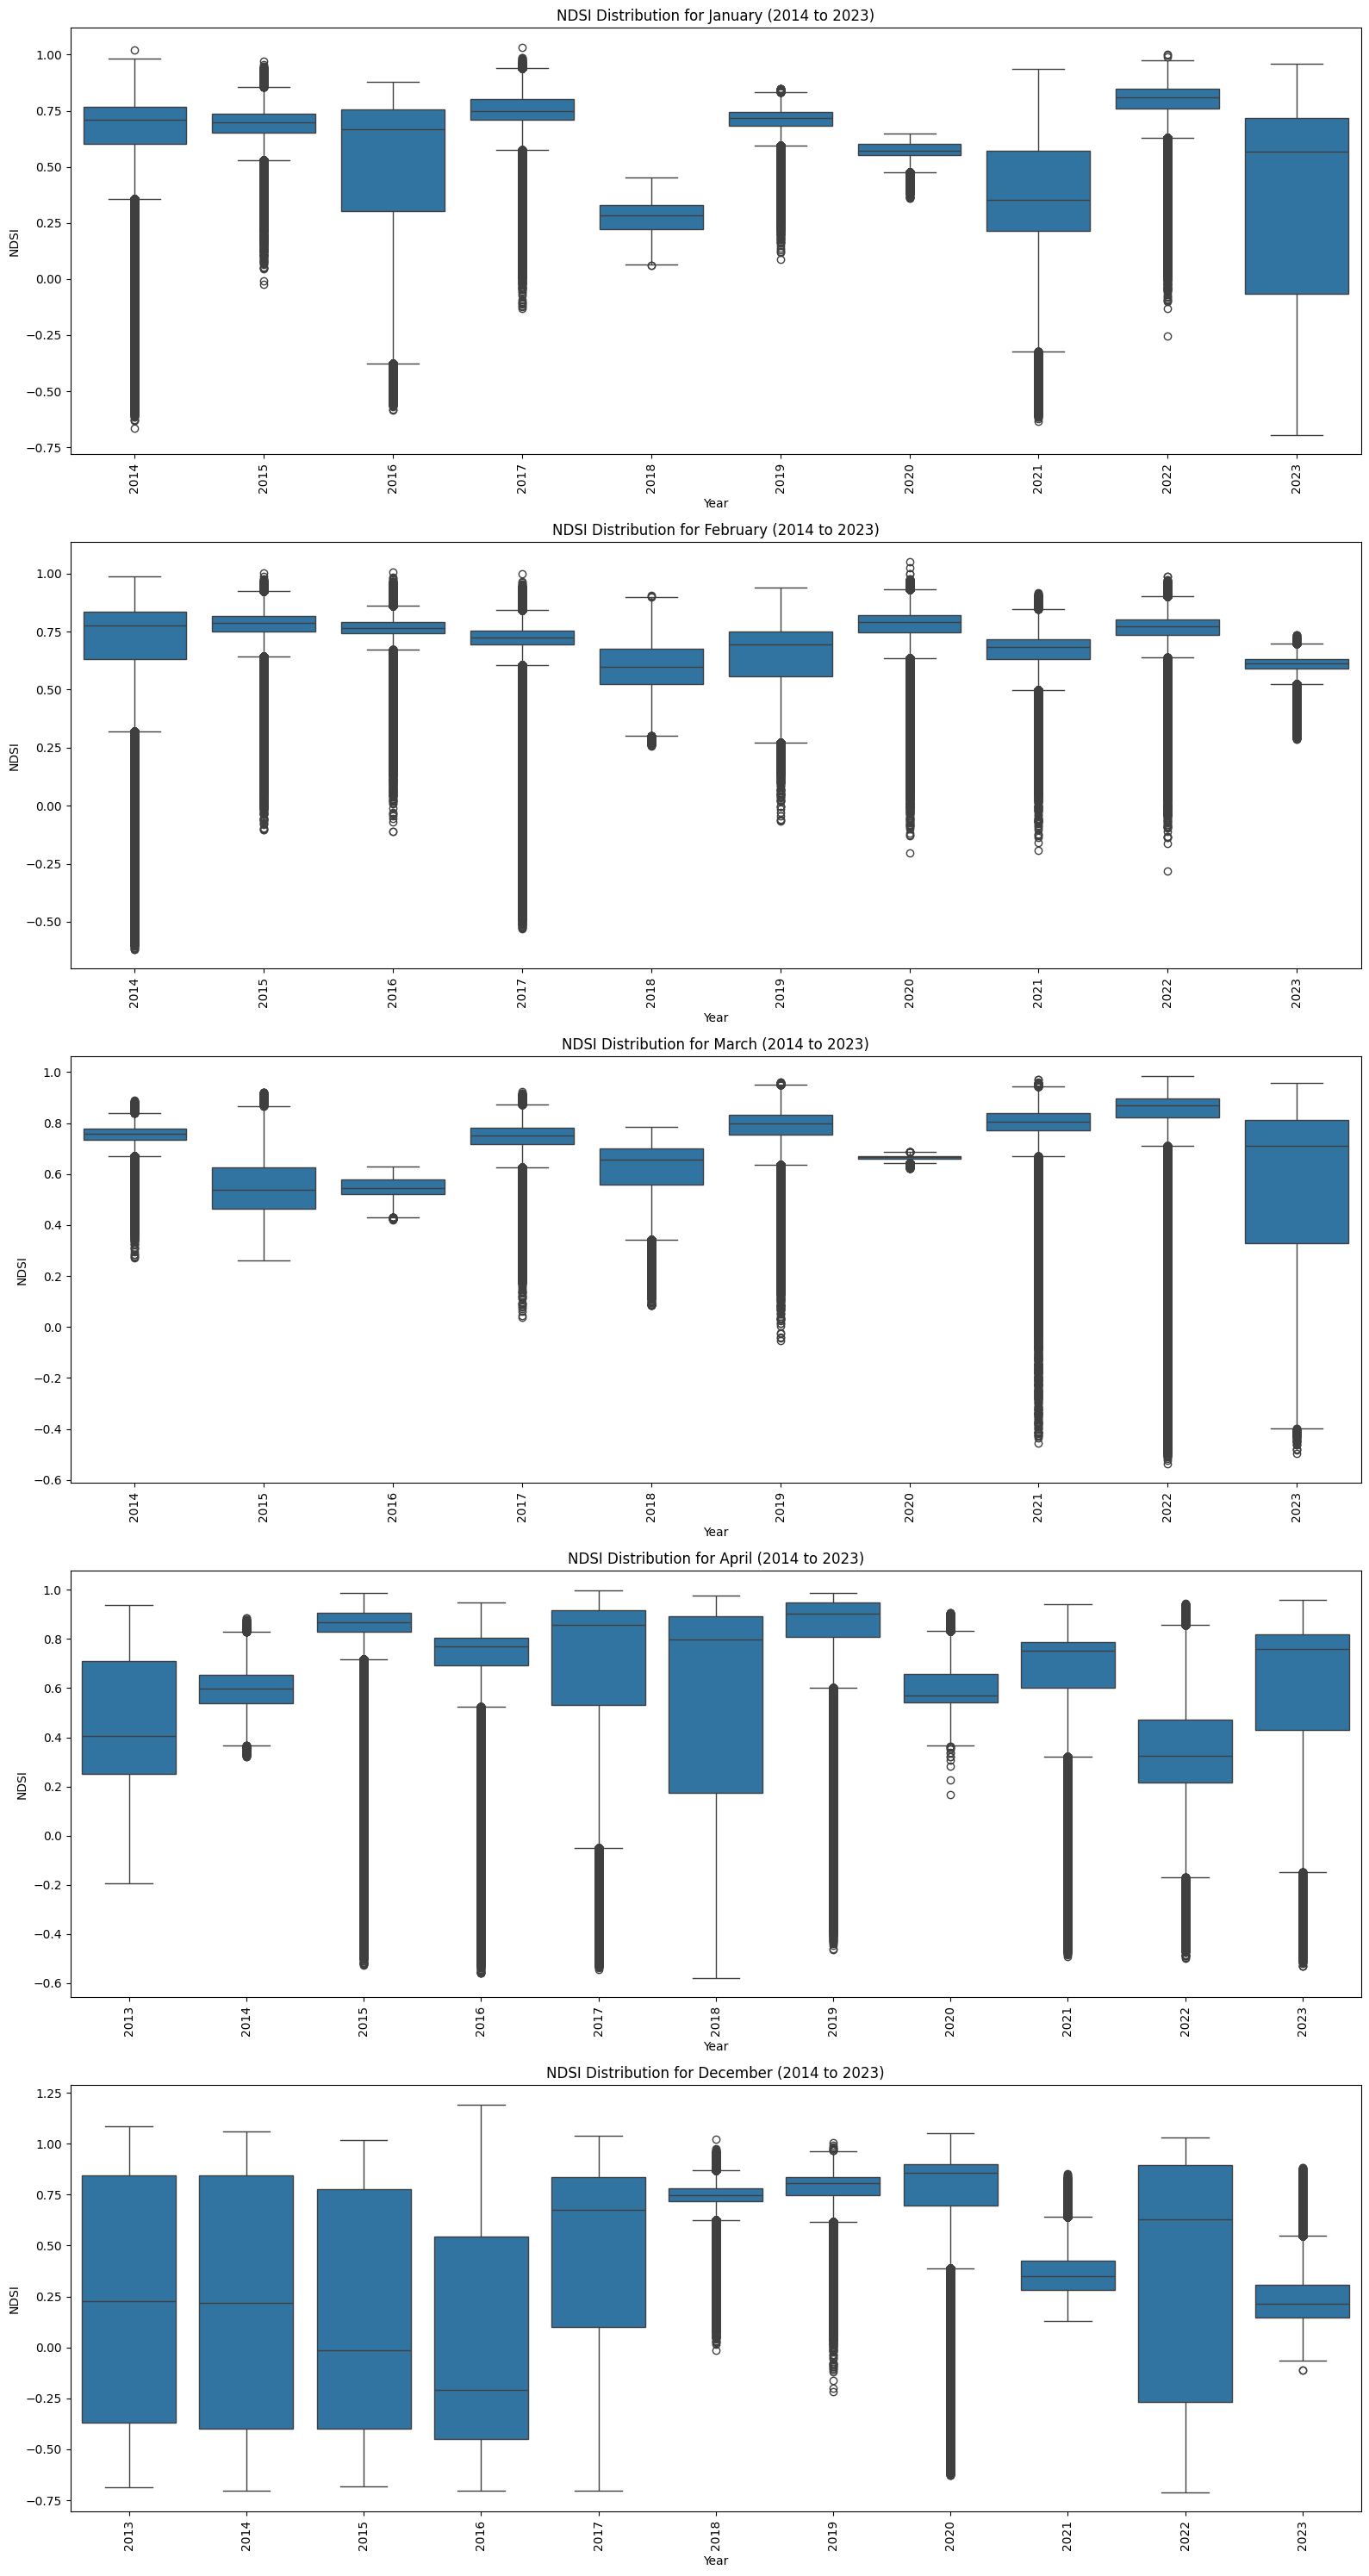

In [15]:
# Define the order of months for separate subplots: Jan to Apr, then Dec
months_in_order = [1, 2, 3, 4, 12]

# Filter for December to April only
df_dec_to_apr = df_pure_ndsi[df_pure_ndsi['month'].isin(months_in_order)]

# Add 'month_year' column if not already added
df_dec_to_apr['month_year'] = df_dec_to_apr['year'].astype(str) + '-' + df_dec_to_apr['month'].astype(str).str.zfill(2)

# Initialize a subplot for each month across all years in the sequence Jan, Feb, Mar, Apr, Dec
num_plots = len(months_in_order)
fig, axes = plt.subplots(num_plots, 1, figsize=(16, 6 * num_plots))

# Plot each month across all years in its own subplot
for idx, month in enumerate(months_in_order):
    # Filter data for the specific month across all years
    month_data = df_dec_to_apr[df_dec_to_apr['month'] == month]
    
    # Create box plot for the specific month
    sns.boxplot(x='year', y='ndsi', data=month_data, ax=axes[idx])
    
    # Set plot title and labels
    month_name = month_data['month'].map({1: "January", 2: "February", 3: "March", 4: "April", 12: "December"}).iloc[0]
    axes[idx].set_title(f'NDSI Distribution for {month_name} (2014 to 2023)')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('NDSI')
    
    # Rotate x-axis labels for readability
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [18]:
start_date = ee.Date.fromYMD(2014, 12, 1)
end_date = ee.Date.fromYMD(2015, 1, 1)
geometry = ee.Geometry.Rectangle([78.97, 30.70, 79.20, 30.79])

# Filter image collection for the date range and region
image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                    .filterDate(start_date, end_date) \
                    .filterBounds(geometry)

def extract_swir(image):
    swir = image.select('B6')
    swir_sample = swir.sample(region=geometry, scale=30, geometries=True)
    # Add the date as a property to each pixel
    date = image.date().format("YYYY-MM-dd")
    swir_sample = swir_sample.map(lambda f: f.set('date', date))
    return swir_sample

# Apply the function to each image in the collection
swir_samples = image_collection.map(extract_swir).flatten()

# Limit to a manageable sample size for direct retrieval
sample_size = 50000  # Adjust this value if you get memory errors
swir_data = swir_samples.limit(sample_size).getInfo()

data = []
for feature in swir_data['features']:
    date = feature['properties']['date']
    swir_value = feature['properties']['B6']
    coordinates = feature['geometry']['coordinates']
    data.append({'date': date, 'swir_value': swir_value, 'lon': coordinates[0], 'lat': coordinates[1]})

swir_df = pd.DataFrame(data)

EEException: Collection query aborted after accumulating over 5000 elements.